In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [4]:
df = pd.read_csv('/content/drive/MyDrive/dataset/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df_clean = df.copy()

In [6]:
df_clean.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [7]:
df_num  = np.array([i for i in df_clean.dtypes.index if df_clean.dtypes[i] == 'int64' or df_clean.dtypes[i] == 'float64'])
df_num_diff = np.array(['FastingBS', 'HeartDisease'])
df_num = np.setdiff1d(df_num,df_num_diff)

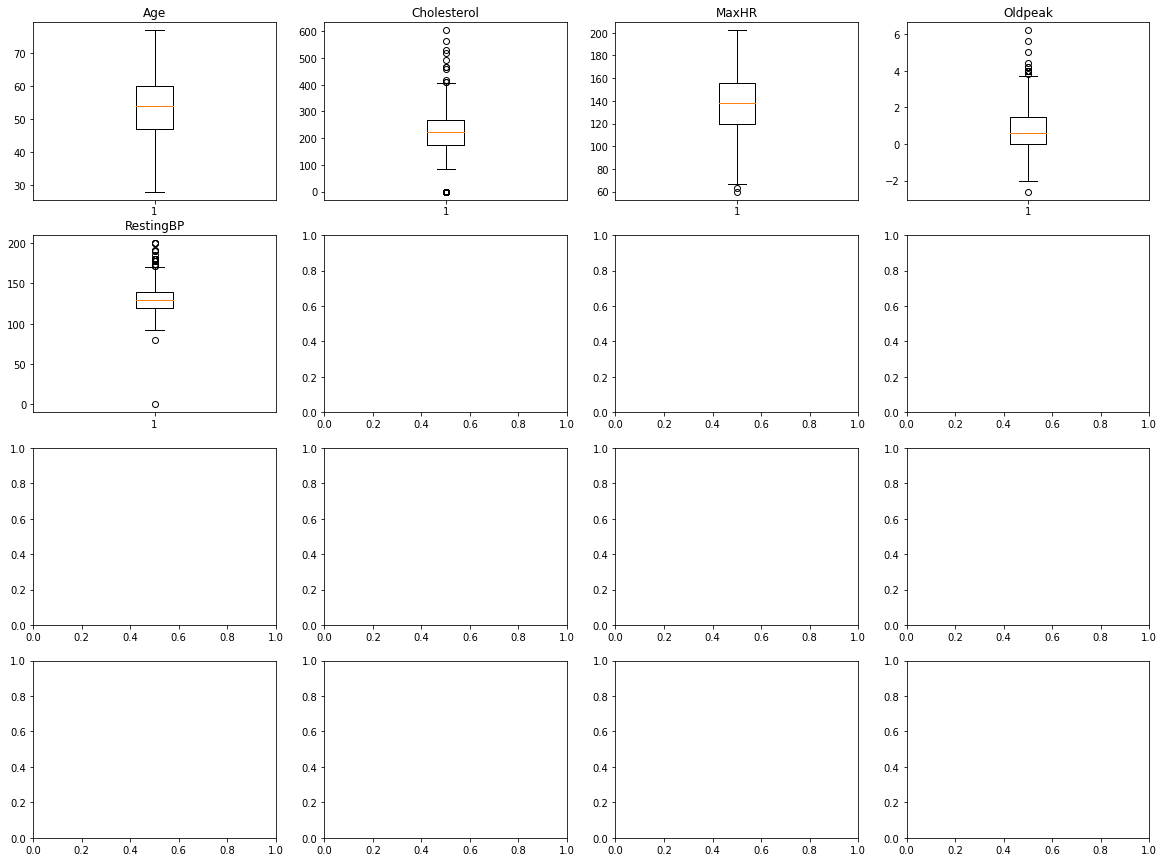

In [8]:
fig, axs = plt.subplots(4, 4, figsize =(20,15))

cnt = 0
for i in range(4):
  for j in range(4):
    if cnt == len(df_num):
      break
    axs[i, j].boxplot(df_clean[df_num[cnt]])
    axs[i, j].set_title(df_num[cnt])
    cnt = cnt + 1

In [9]:
for i in df_num:
  tenth_q = df_clean[i].quantile(0.10)
  ninth_q = df_clean[i].quantile(0.90)
  df_clean[i] = np.where(df_clean[i] < tenth_q, tenth_q, df_clean[i])
  df_clean[i] = np.where(df_clean[i] > ninth_q, ninth_q, df_clean[i])

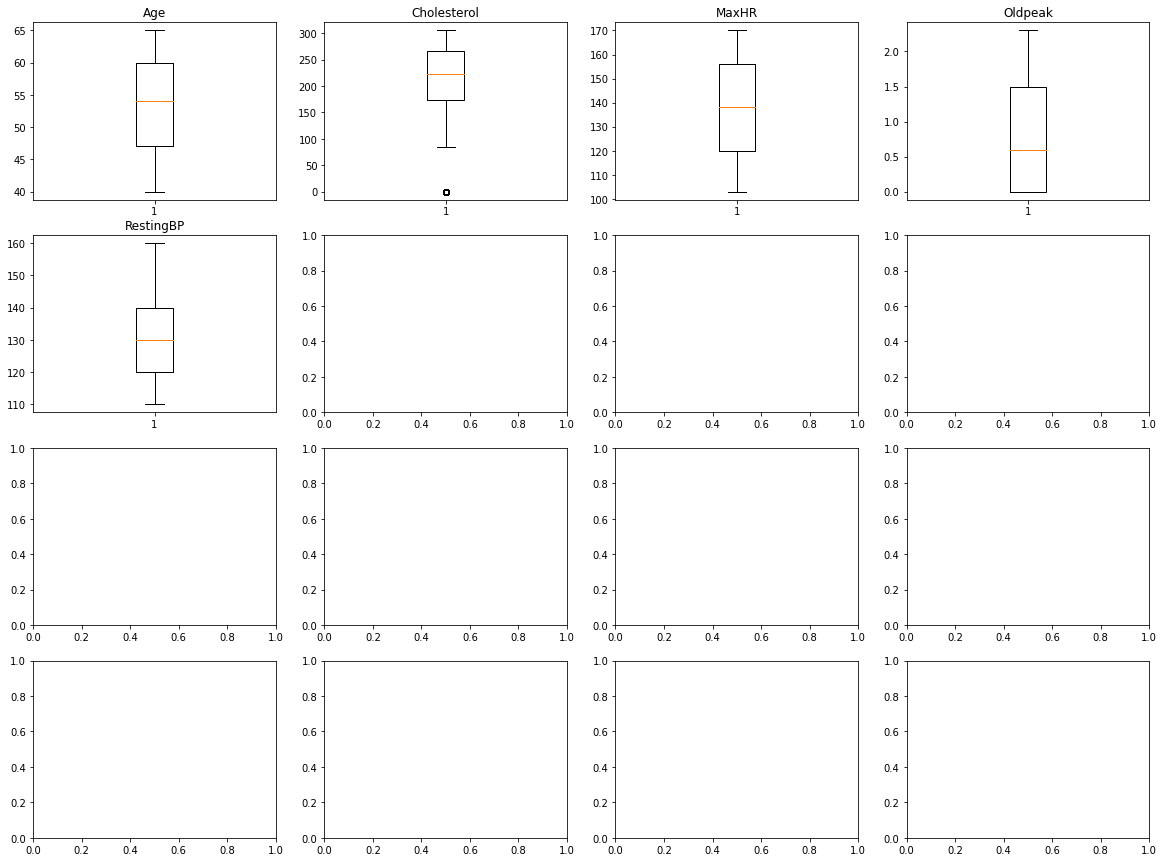

In [10]:
fig, axs = plt.subplots(4, 4, figsize =(20,15))

cnt = 0
for i in range(4):
  for j in range(4):
    if cnt == len(df_num):
      break
    axs[i, j].boxplot(df_clean[df_num[cnt]])
    axs[i, j].set_title(df_num[cnt])
    cnt = cnt + 1

In [11]:
df_wrag = df_clean.copy()

In [12]:
df_str = [i for i in df_wrag.dtypes.index if df_wrag.dtypes[i] == 'object']

In [13]:
df_bin = [i for i in df_str if len(df_wrag[i].unique()) == 2]
df_category = [i for i in df_str if len(df_wrag[i].unique()) > 2]

In [14]:
label_encoder = LabelEncoder()
for i in df_bin:
  df_wrag[i] = label_encoder.fit_transform(df_wrag[i])

In [15]:
df_wrag[df_bin].head()

,Sex,ExerciseAngina
0,1,0
1,0,0
2,1,0
3,0,1
4,1,0


In [16]:
for i in df_category:
  mean_encoded = df_wrag.groupby(i)['HeartDisease'].mean().to_dict()
  df_wrag[i] = df_wrag[i].map(mean_encoded)

In [17]:
df_wrag[df_category].head()

,ChestPainType,RestingECG,ST_Slope
0,0.138728,0.516304,0.197468
1,0.354680,0.516304,0.828261
2,0.138728,0.657303,0.197468
3,0.790323,0.516304,0.828261
4,0.354680,0.516304,0.197468


In [18]:
X = df_wrag.drop('HeartDisease', axis=1)
y = df_wrag['HeartDisease']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

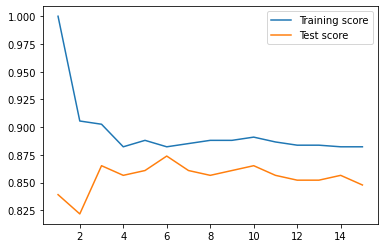

In [21]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbor = np.arange(1,16)
train_score = []
test_score = []

for i in n_neighbor:
  knn = KNeighborsClassifier(n_neighbors=i).fit(X_train_scaled, y_train)
  train_score.append(knn.score(X_train_scaled, y_train))
  test_score.append(knn.score(X_test_scaled, y_test))

plt.plot(n_neighbor, train_score, label='Training score')
plt.plot(n_neighbor, test_score, label='Test score')
plt.legend()
plt.show()

In [22]:
param_grid = {"n_neighbors":np.arange(1,16)}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid)
knn_grid.fit(X_train_scaled, y_train)

knn_best = KNeighborsClassifier(n_neighbors=knn_grid.best_params_['n_neighbors']).fit(X_train_scaled, y_train)
print(knn_grid.best_params_)
print(knn_best.score(X_train_scaled, y_train))
print(knn_best.score(X_test_scaled, y_test))

{'n_neighbors': 13}
0.8837209302325582
0.8521739130434782


In [23]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty = 'l2', max_iter=1000).fit(X_train_scaled, y_train)
print("Train score : {:.4f}".format(logreg.score(X_train_scaled, y_train)))
print("Test score : {:.4f}".format(logreg.score(X_test_scaled, y_test)))

Train score : 0.8735
Test score : 0.8348


In [24]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=42).fit(X_train_scaled, y_train)
print("Train score : {:.4f}".format(tree_clf.score(X_train_scaled, y_train)))
print("Train score : {:.4f}".format(tree_clf.score(X_test_scaled, y_test)))

Train score : 1.0000
Train score : 0.8000


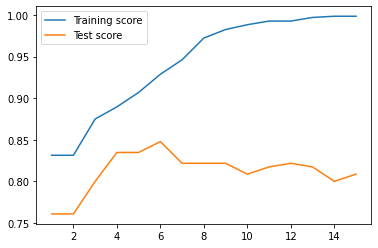

In [25]:
max_depth = np.arange(1,16)
train_score = []
test_score = []

for i in max_depth:
  tree_clf = DecisionTreeClassifier(max_depth=i, random_state=42).fit(X_train_scaled, y_train)
  train_score.append(tree_clf.score(X_train_scaled, y_train))
  test_score.append(tree_clf.score(X_test_scaled, y_test))

plt.plot(max_depth, train_score, label='Training score')
plt.plot(max_depth, test_score, label='Test score')
plt.legend()
plt.show()

In [26]:
param_grid = {"max_depth":np.arange(1,16)}
tree_grid = GridSearchCV(DecisionTreeClassifier(), param_grid)
tree_grid.fit(X_train_scaled, y_train)

tree_best = DecisionTreeClassifier(max_depth=tree_grid.best_params_['max_depth']).fit(X_train_scaled, y_train)
print(tree_grid.best_params_)
print(tree_best.score(X_train_scaled, y_train))
print(tree_best.score(X_test_scaled, y_test))

{'max_depth': 3}
0.875
0.8


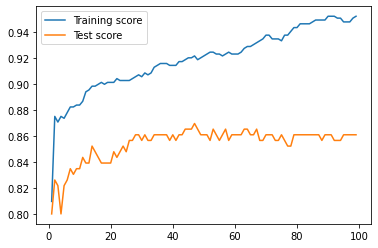

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
n_estimators = np.arange(1,100)
train_score = []
test_score = []

for i in n_estimators:
  gbc = GradientBoostingClassifier(n_estimators=i, random_state=42).fit(X_train_scaled, y_train)
  train_score.append(gbc.score(X_train_scaled, y_train))
  test_score.append(gbc.score(X_test_scaled, y_test))

plt.plot(n_estimators, train_score, label='Training score')
plt.plot(n_estimators, test_score, label='Test score')
plt.legend()
plt.show()

In [28]:
param_grid = {"n_estimators":np.arange(1,100)}
gbd_grid = GridSearchCV(GradientBoostingClassifier(), param_grid)
gbd_grid.fit(X_train_scaled, y_train)

gbd_best = GradientBoostingClassifier(n_estimators=gbd_grid.best_params_['n_estimators']).fit(X_train_scaled, y_train)
print(gbd_grid.best_params_)
print(gbd_best.score(X_train_scaled, y_train))
print(gbd_best.score(X_test_scaled, y_test))

{'n_estimators': 23}
0.9026162790697675
0.8478260869565217


In [29]:
from xgboost import XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss').fit(X_train_scaled, y_train)
print(xgb.score(X_train_scaled, y_train))
print(xgb.score(X_test_scaled, y_test))

0.934593023255814
0.8652173913043478


In [30]:
knn_pred = knn_best.predict(X_test_scaled)
logreg_pred = logreg.predict(X_test_scaled)
tree_pred = tree_best.predict(X_test_scaled)
gbd_pred = gbd_best.predict(X_test_scaled)
xgb_pred = xgb.predict(X_test_scaled)

In [34]:
print("F1 score K-NN : {:.4f}".format(f1_score(y_test, knn_pred, average='binary')))
print("F1 score Logistic Regression : {:.4f}".format(f1_score(y_test, logreg_pred, average='binary')))
print("F1 score Decision Tree : {:.4f}".format(f1_score(y_test, tree_pred, average='binary')))
print("F1 score Gradient Boosting Classifier : {:.4f}".format(f1_score(y_test, gbd_pred, average='binary')))
print("F1 score XGBoost Classifier : {:.4f}".format(f1_score(y_test, xgb_pred, average='binary')))

F1 score knn : 0.8803
F1 score Logistic Regression : 0.8671
F1 score Decision Tree : 0.8345
F1 score Gradient Boosting Classifier : 0.8772
F1 score XGBoost Classifier : 0.8905


In [32]:
from sklearn.metrics import classification_report, cohen_kappa_score, hamming_loss

In [35]:
print("F1 score K-NN : {:.4f}".format(cohen_kappa_score(y_test, knn_pred)))
print("F1 score Logistic Regression : {:.4f}".format(cohen_kappa_score(y_test, logreg_pred)))
print("F1 score Decision Tree : {:.4f}".format(cohen_kappa_score(y_test, tree_pred)))
print("F1 score Gradient Boosting Classifier : {:.4f}".format(cohen_kappa_score(y_test, gbd_pred)))
print("F1 score XGBoost Classifier : {:.4f}".format(cohen_kappa_score(y_test, xgb_pred)))

F1 score K-NN : 0.6875
F1 score Logistic Regression : 0.6494
F1 score Decision Tree : 0.5818
F1 score Gradient Boosting Classifier : 0.6777
F1 score XGBoost Classifier : 0.7156
